# training pytorch cnn

## 事前準備

In [1]:
!pip install torchinfo -q

In [2]:
!pip list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
accelerate                            1.10.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.10.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  25.1.0
array_record                          0.7.2
arviz                                 0.22.0
astropy                               7.1.0
astrop

In [3]:
import torch

torch.__version__

'2.6.0+cu124'

In [10]:
# GPUが使えるか確認してデバイスを設定
# NOTE: `x = x.to(device) ` とすることで対象のデバイスに切り替え可能
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## CNN

In [4]:
# @title DataLoader設定
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# transformを準備
affine = transforms.RandomAffine((-30, 30), scale=(0.8, 1.2))
flip = transforms.RandomHorizontalFlip(p=0.5)
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均0、標準偏差1

transform_train = transforms.Compose([
    affine,
    flip,
    transforms.ToTensor(),
    normalize
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# DataLoader作成
cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
cifar10_classes = cifar10_train.classes

# DataLoaderの設定
batch_size = 128
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 43.6MB/s]


In [5]:
len(cifar10_train), len(cifar10_test)

(50000, 10000)

In [13]:
# @title モデル構築
from torch import nn

class Net(nn.Module):
    def __init__(self, n_classes: int):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)         # 入力チャネル、出力チャネル、フィルタ数
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)          # 領域のサイズ、領域の間隔
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 256)
        self.dropout = nn.Dropout(0.5)          # ドロップアウト率
        self.fc2 = nn.Linear(256, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        入力画像: (3, 32, 32)
        conv1   : (8, 28, 28)
        pool    : (8, 14, 14)
        conv2   : (16, 10, 10)
        pool    : (16, 5, 5)
        fc1     : (256)
        fc2     : (10)
        """
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [7]:
net = Net(len(cifar10_classes))

In [8]:
import torchinfo

torchinfo.summary(net, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 8, 28, 28]            608
├─ReLU: 1-2                              [1, 8, 28, 28]            --
├─MaxPool2d: 1-3                         [1, 8, 14, 14]            --
├─Conv2d: 1-4                            [1, 16, 10, 10]           3,216
├─ReLU: 1-5                              [1, 16, 10, 10]           --
├─MaxPool2d: 1-6                         [1, 16, 5, 5]             --
├─Linear: 1-7                            [1, 256]                  102,656
├─ReLU: 1-8                              [1, 256]                  --
├─Dropout: 1-9                           [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 109,050
Trainable params: 109,050
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.90
Input size (MB): 0.01
Forward/b

In [ ]:
# @title 学習
from torch import optim

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

record_loss_train = []
record_loss_test = []

n_epochs = 20
verbose = 1

for epoch in range(n_epochs):
    net.train()
    loss_train = 0.0

    for j, (x, t) in enumerate(train_loader):
        x, t = x.to(device), t.to(device)
        y = net(x)

        loss = loss_func(y, t)
        loss_train += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_train /= j + 1
    record_loss_train.append(loss_train)

    net.eval()
    loss_test = 0.0

    for j, (x, t) in enumerate(test_loader):
        x, t = x.to(device), t.to(device)
        y = net(x)

        loss = loss_func(y, t)
        loss_test += loss.item()

    loss_test /= j + 1
    record_loss_test.append(loss_test)

    if epoch % verbose == 0:
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_test: {loss_test:.4f}')

epoch: 1, loss_train: 1.8739, loss_test: 1.6474
epoch: 2, loss_train: 1.6439, loss_test: 1.4850
epoch: 3, loss_train: 1.5671, loss_test: 1.4253
epoch: 4, loss_train: 1.5243, loss_test: 1.3673
epoch: 5, loss_train: 1.4837, loss_test: 1.3132
epoch: 6, loss_train: 1.4507, loss_test: 1.2829
epoch: 7, loss_train: 1.4161, loss_test: 1.3006
epoch: 8, loss_train: 1.4123, loss_test: 1.2754
epoch: 9, loss_train: 1.3878, loss_test: 1.2607
epoch: 10, loss_train: 1.3739, loss_test: 1.2374
epoch: 11, loss_train: 1.3556, loss_test: 1.2143
epoch: 12, loss_train: 1.3471, loss_test: 1.1979
epoch: 13, loss_train: 1.3340, loss_test: 1.1781
epoch: 14, loss_train: 1.3250, loss_test: 1.1512
epoch: 15, loss_train: 1.3197, loss_test: 1.1482
epoch: 16, loss_train: 1.3089, loss_test: 1.1320
epoch: 17, loss_train: 1.2971, loss_test: 1.1302
epoch: 18, loss_train: 1.2871, loss_test: 1.1199
epoch: 19, loss_train: 1.2820, loss_test: 1.1140
epoch: 20, loss_train: 1.2774, loss_test: 1.1250


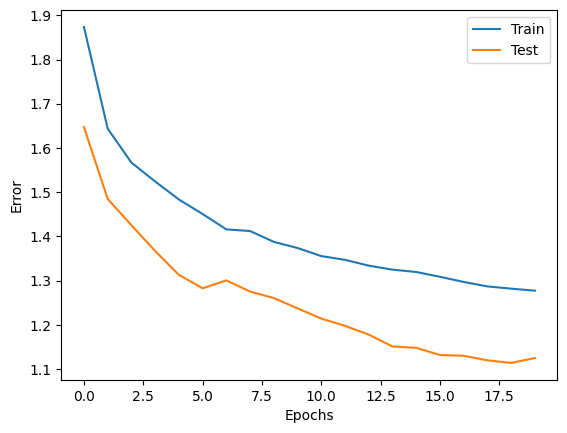

In [26]:
# @title 誤差の推移
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label='Train')
plt.plot(range(len(record_loss_test)), record_loss_test, label='Test')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [27]:
# @title 正解率
correct = 0
total = 0

net.eval()

for j, (x, t) in enumerate(test_loader):
    x, t = x.to(device), t.to(device)
    y = net(x)

    correct += (y.argmax(1) == t).sum().item()
    total += len(x)

print(f"accuracy: {correct / total}")

accuracy: 0.6059


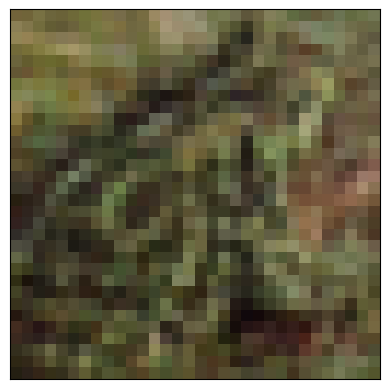

answer: frog, predict: frog


In [37]:
# @title 訓練済みモデルを使用した予測
def get_sample_image() -> tuple[torch.Tensor, torch.Tensor]:
    cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)

    images, labels = next(iter(cifar10_loader))

    select_index = 0
    return images[select_index], labels[select_index]

def show_image(image: torch.Tensor) -> None:
    plt.imshow(image.permute(1, 2, 0))
    # ラベルとメモリを非表示に設定
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    plt.show()

image, label = get_sample_image()
show_image(image)

net.eval()
image, label = image.to(device), label.to(device)
y = net(image)

print(f"answer: {cifar10_classes[label]}, predict: {cifar10_classes[y.argmax().item()]}")